## References

see README.md

In [1]:
import os
import itertools


import datetime

import editdistance
import numpy as np

import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks

Using TensorFlow backend.


In [2]:
OUTPUT_DIR = 'image_ocr'



np.random.seed(55)

In [3]:
import generator_text_image as fake
import ctc_drop_first_2
import cnn_rnn_model

In [4]:
# the actual loss calc occurs here despite it not being
# an internal Keras loss function




## Predict


In [5]:
# update this path with the date from your run of this notebook
weight_file = './image_ocr/2019:06:06:21:44:07/weights24.h5'

In [6]:

img_w = 128
# Input Parameters
img_h = 64
words_per_epoch = 16000
val_split = 0.2
val_words = int(words_per_epoch * (val_split))

# Network parameters

pool_size = 2
minibatch_size = 32


fdir = os.path.dirname(get_file('wordlists.tgz',
                                origin='http://www.mythic-ai.com/datasets/wordlists.tgz', untar=True))

img_gen = fake.TextImageGenerator(monogram_file=os.path.join(fdir, 'wordlist_mono_clean.txt'),
                             bigram_file=os.path.join(fdir, 'wordlist_bi_clean.txt'),
                             minibatch_size=minibatch_size,
                             img_w=img_w,
                             img_h=img_h,
                             downsample_factor=(pool_size ** 2),
                             val_split=words_per_epoch - val_words
                             )

model, input_data, y_pred = cnn_rnn_model.make_model(img_w, img_h, pool_size, img_gen.get_output_size(), img_gen.absolute_max_string_len)
    
# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)



model.summary() # print summary of model
    
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
model.load_weights(weight_file)
# captures output of softmax so we can decode the output during visualization
test_func = K.function([input_data], [y_pred])


770048/768223 [==============================] - 1s 1us/step
Instructions for updating:
Colocations handled automatically by placer.
Tensor("the_labels:0", shape=(?, 16), dtype=float32)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
_________________________

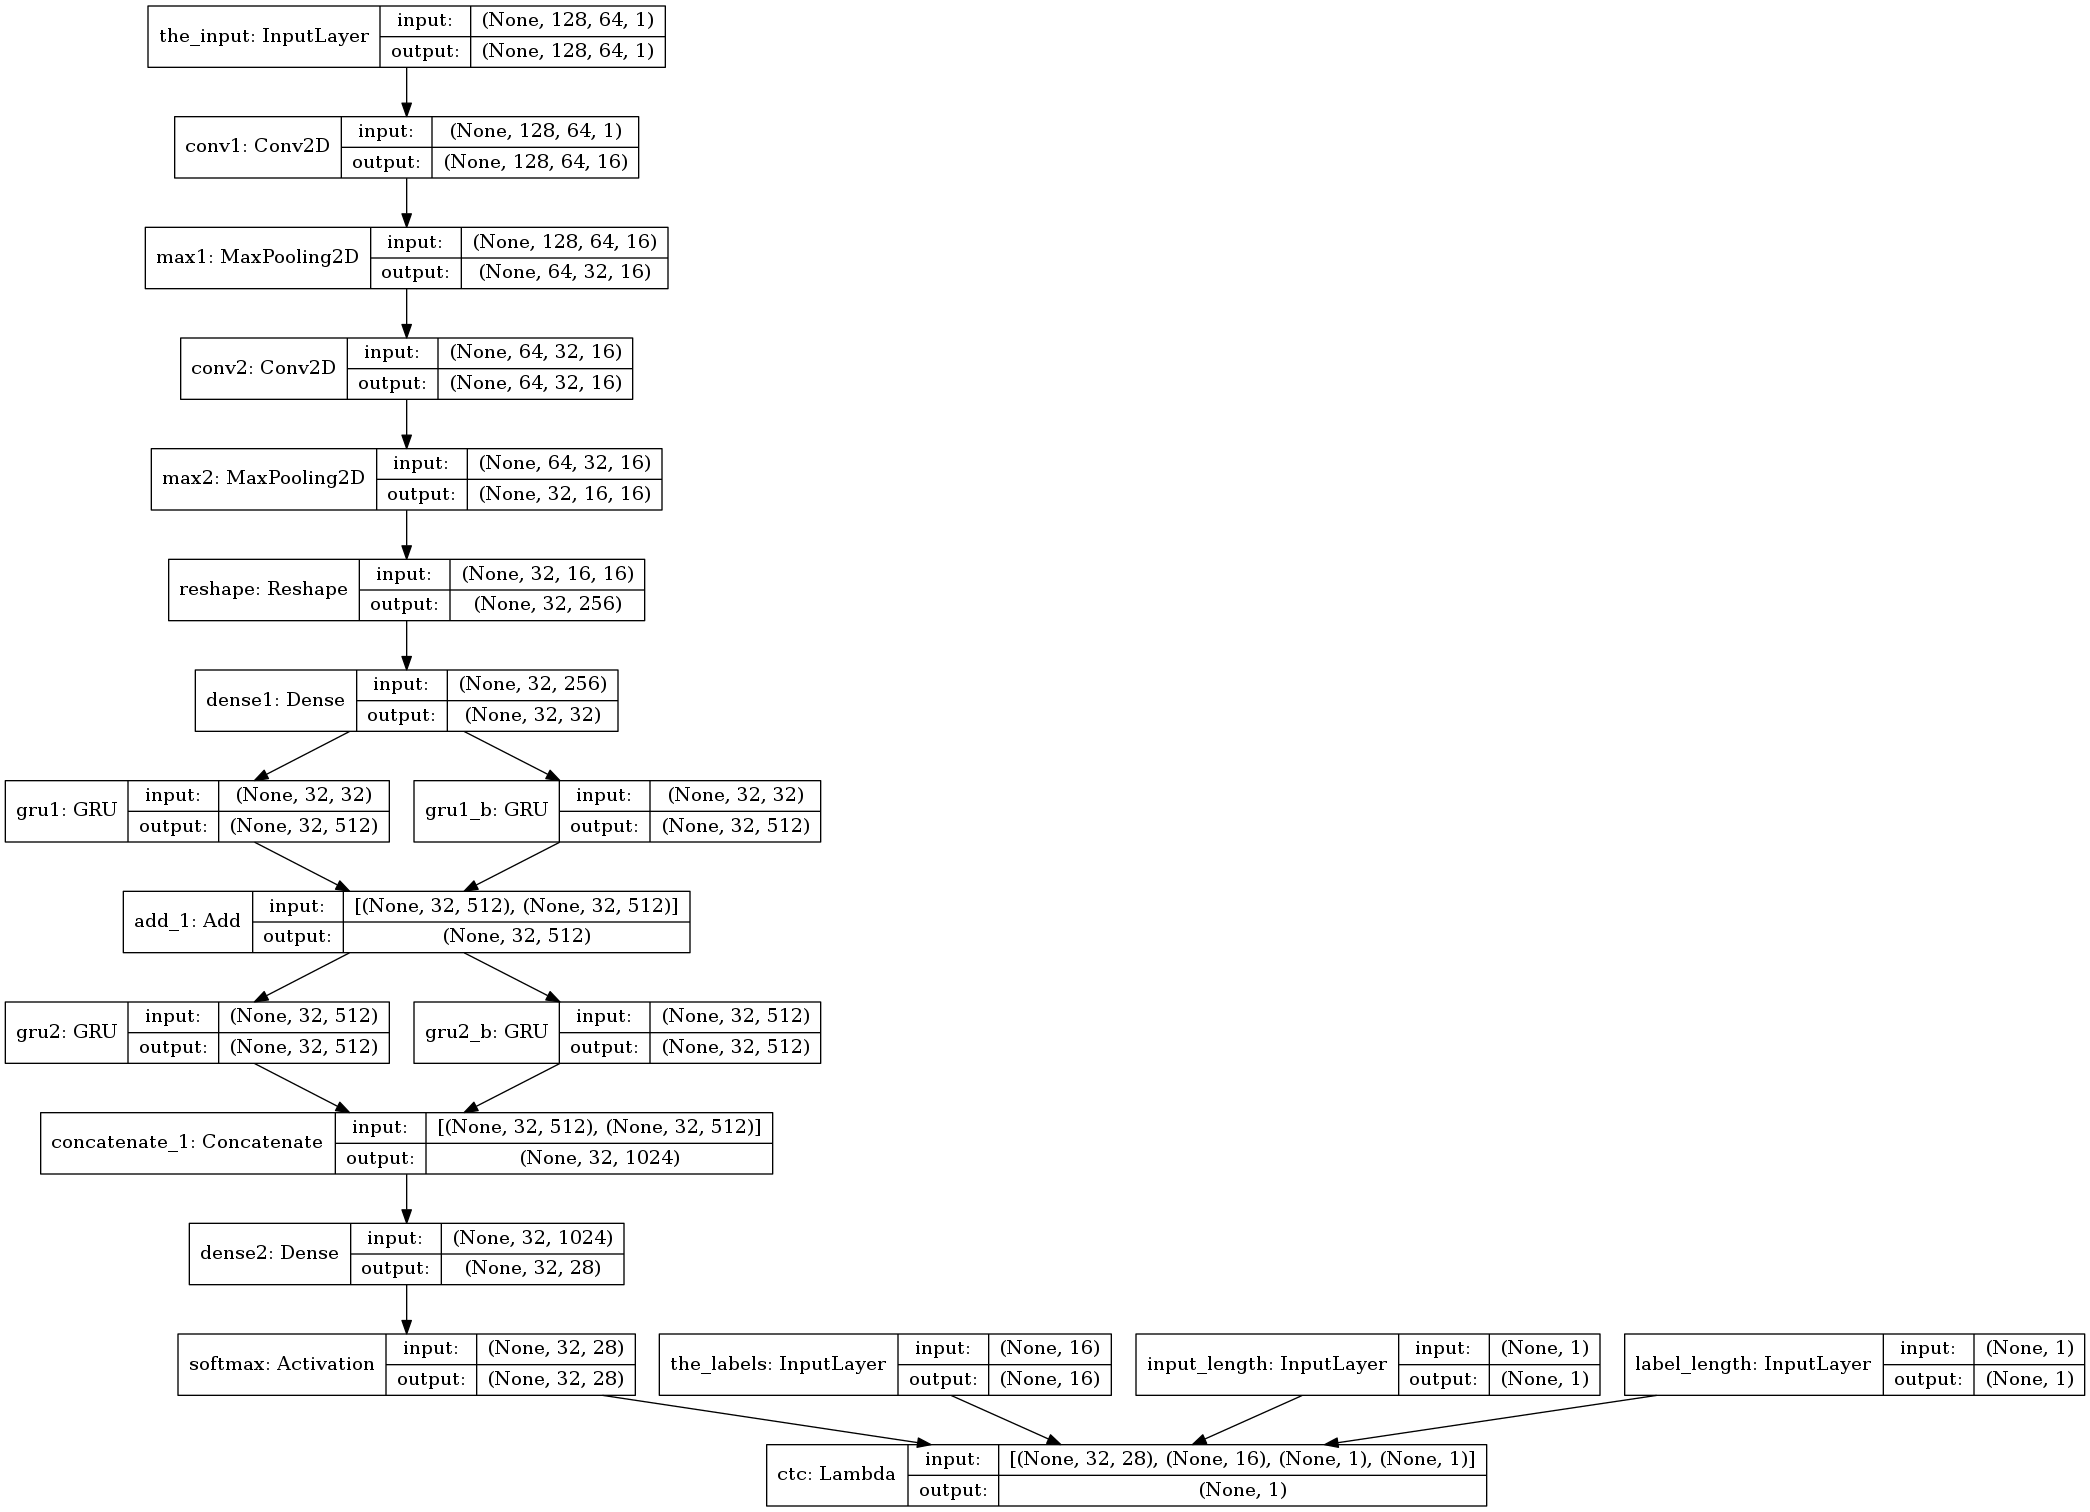

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [8]:
model_p = Model(inputs=input_data, outputs=y_pred)

In [9]:
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
      beam_width = top_paths
    for i in range(top_paths):
      lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
      text = fake.labels_to_text(lables)
      results.append(text)
    return results
  
def predit_a_image(a, top_paths = 1):
  c = np.expand_dims(a.T, axis=0)
  net_out_value = model_p.predict(c)
  top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
  return top_pred_texts



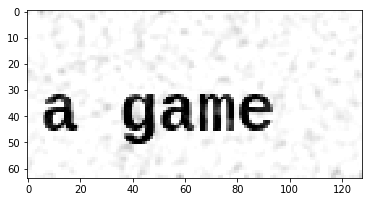

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


['a game']

In [10]:
h = 64
w = 128
a = fake.paint_text('a game',h = h, w = w)
b = a.reshape((h, w))
plt.imshow(b, cmap='Greys_r')
plt.show()

c = np.expand_dims(a.T, axis=0)

net_out_value = model_p.predict(c)
pred_texts = decode_predict_ctc(net_out_value)
pred_texts

In [11]:
predit_a_image(a, top_paths = 3)

['a game', 'ala game', 'a gzme']

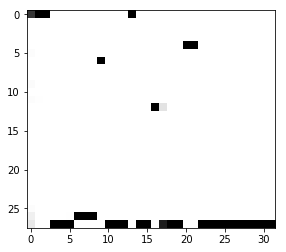

In [12]:
plt.imshow(net_out_value[0].T, cmap='binary', interpolation='nearest')
plt.show()

In [13]:
K.get_value(K.ctc_decode(net_out_value, input_length=np.ones(net_out_value.shape[0])*net_out_value.shape[1],
                         greedy=False, beam_width=3, top_paths=3)[0][0])

array([[ 0, 26,  6,  0, 12,  4]])

In [14]:
K.ctc_decode(net_out_value, input_length=np.ones(net_out_value.shape[0])*net_out_value.shape[1],
                         greedy=False, beam_width=5, top_paths=3)

([<tf.Tensor 'SparseToDense_13:0' shape=(1, 6) dtype=int64>,
  <tf.Tensor 'SparseToDense_14:0' shape=(1, 8) dtype=int64>,
  <tf.Tensor 'SparseToDense_15:0' shape=(1, 6) dtype=int64>],
 <tf.Tensor 'CTCBeamSearchDecoder_5:9' shape=(1, 3) dtype=float32>)

In [15]:
!ls

__pycache__	     generator_text_image.py  model.png
cnn_rnn_model.py     image-ocr-disect.ipynb   predict.ipynb
ctc_drop_first_2.py  image_ocr		      train.ipynb


In [16]:
K.get_value(K.ctc_decode(net_out_value, input_length=np.ones(net_out_value.shape[0])*net_out_value.shape[1],
                         greedy=False, beam_width=3, top_paths=3)[0][0])

array([[ 0, 26,  6,  0, 12,  4]])

In [17]:
K.ctc_decode?